# Libraries and Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import datetime

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer

In [2]:
warnings.filterwarnings('ignore')

In [3]:
train = pd.read_csv("../data/advanced_train.csv", low_memory = False)
test = pd.read_csv("../data/advanced_test.csv", low_memory = False)

# Data Pre-Processing

In [35]:
# Make some manual adjustments to prices to remove outliers
train["Last Sold Price"] = np.where((train["Last Sold Price"] / train["Sold Price"] > 10) |
                                     (train["Last Sold Price"] / train["Sold Price"] < 0.1),
                                     np.NaN,
                                     train["Last Sold Price"])
train["Listed Price"] = np.where((train["Listed Price"] / train["Sold Price"] > 10) |
                                  (train["Listed Price"] / train["Sold Price"] < 0.1),
                                 np.NaN,
                                 train["Listed Price"])

In [36]:
imp = KNNImputer(n_neighbors = 10)

imp_vars = ["Total interior livable area", "Full bathrooms", "Bathrooms",
           "Total spaces", "Elementary School Score", "Elementary School Distance", 
           "Middle School Score", "Middle School Distance", "High School Score",
           "High School Distance", "Year built", "Garage spaces", "Listed Price", "Last Sold Price"] # , "Lot"

In [37]:
imp.fit(train[imp_vars])

KNNImputer(n_neighbors=10)

In [38]:
parking_types_train = train["Parking"].str.lower().str.replace(" ", "").str.split(",").explode().value_counts()
heating_types_train = train["Heating"].str.lower().str.replace(" ", "").str.split(",").explode().value_counts()
flooring_types_train = train["Flooring"].str.lower().str.replace(" ", "").str.split(",").explode().value_counts()
appliance_types_train = train["Appliances included"].str.lower().str.replace(" ", "").str.split(",").explode().value_counts()
cities_train = train["City"].value_counts().head(200)
types_train = train["Type"].str.lower().str.replace(" ", "").value_counts().head(20)
laundry_types_train = train["Laundry features"].str.lower().str.replace(" ", "").str.split(",").explode().value_counts()


train_medians = train.median()
test_medians = test.median()

def preprocess_data(df, imp, imp_v, meds, ptypes_train, htypes_train, ftypes_train, atypes_train, cities, ttypes_train, ltypes_train):
    
    df[imp_v] = imp.transform(df[imp_v]) 
    
    df["Total interior livable area"] = df["Total interior livable area"].fillna(meds["Total interior livable area"])
    
    df["Bathrooms"] = df["Bathrooms"].fillna(meds["Bathrooms"])
    
    df["Total spaces"] = df["Total spaces"].fillna(meds["Total spaces"])
    df["Total spaces"] = np.abs(np.minimum(df["Total spaces"], 30))
    
    df["Elementary School Score"] = df["Elementary School Score"].fillna(meds["Elementary School Score"])
    df["Elementry School Distance"] = df["Elementary School Distance"].fillna(meds["Elementary School Distance"])
    
    df["Middle School Score"] = df["Middle School Score"].fillna(meds["Middle School Score"])
    df["Middle School Distance"] = df["Middle School Distance"].fillna(meds["Middle School Distance"])

    df["High School Score"] = df["High School Score"].fillna(meds["High School Score"])
    df["High School Distance"] = df["High School Distance"].fillna(meds["High School Distance"])
    
    df["Year built"] = df["Year built"].fillna(meds["Year built"])
    df["Year built"] = np.maximum(df["Year built"], 1870)
    df["Year built"] = np.minimum(df["Year built"], 2022)
    
    df["state_ind"] = df["State"] == "CA"
    
    df["Garage spaces"] = df["Garage spaces"].fillna(meds["Garage spaces"])
    df["Garage spaces"] = np.maximum(df["Garage spaces"], 0)
    df["Garage spaces"] = np.minimum(df["Garage spaces"], 20)
    
    
    df["Full bathrooms"] = df["Full bathrooms"].fillna(meds["Full bathrooms"])

    # Doesn't seem to matter which impute strategy I use
    #df["l1"] = df["Lot"].fillna(meds["Lot"])
    df["l1"] = df["Lot"].fillna(0)
    
    df["Last Sold Price"] = df["Last Sold Price"].fillna(0)
    df["Last Sold Days"] = (pd.to_datetime("1/1/2021") - pd.to_datetime(df["Last Sold On"].fillna("1/1/2021"))).dt.days
    
    df["Tax assessed value"] = df["Tax assessed value"].replace('#DIV/0!', np.NaN).astype('float').fillna(0)
    
    df["Listed On"] = pd.to_datetime(df["Listed On"]).dt.year + (pd.to_datetime(df["Listed On"]).dt.month/12)
    
    for htype in htypes_train.index:
        df[("h_" + htype)] = df["Heating"].str.lower().str.replace(" ", "").str.contains(htype, na=False)
    
    for ptype in ptypes_train.index:
        df[("p_" + ptype)] = df["Parking"].str.lower().str.replace(" ", "").str.contains(ptype, na=False)
    
    for ftype in ftypes_train.index:
        df[("f_" + ftype)] = df["Flooring"].str.lower().str.replace(" ", "").str.contains(ftype, na=False)

    for atype in atypes_train.index:
        df[("a_" + atype)] = df["Appliances included"].str.lower().str.replace(" ", "").str.contains(atype, na=False)

    for city in cities.index:
        df[city] = df["City"].str.contains(city, na=False)
        
    for ttype in ttypes_train.index:
        df[("t_" + ttype)] = df["Type"].str.lower().str.replace(" ", "").str.contains(ttype, na=False)
    
    for ltype in ltypes_train.index:
        df[("l_" + ltype)] = df["Laundry features"].str.lower().str.replace(" ", "").str.contains(ltype, na=False)

        
    df["r1"] = df["Listed Price"] / (df["Last Sold Price"] + 0.1)
    df["r2"] = df["Last Sold Price"] / (df["Tax assessed value"] + 0.1)
    df["r3"] = df["Tax assessed value"] / (df["Listed Price"] + 0.1)
    
    return df

In [39]:
train_p = preprocess_data(train, imp, imp_vars, train_medians, parking_types_train, 
                          heating_types_train, flooring_types_train, 
                          appliance_types_train, cities_train, types_train,
                         laundry_types_train)


Define the target

In [9]:
y = train["Sold Price"]

In [48]:
pred_vars = ['Listed Price', 'Tax assessed value', 'Listed On', 'r3', 'r1', 
             'Total interior livable area', 'l1', 'Last Sold Price', 'Full bathrooms', 
             'Bathrooms']

X = train_p[pred_vars]

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state = 58)

# Models

In [20]:
params = {"n_estimators":40,
          "learning_rate":0.15,
          "max_depth":3,
          "random_state":56,
          "subsample":1,
          'max_features':None,
          "loss":'squared_error'}

In [21]:
model = GradientBoostingRegressor(verbose = 1).set_params(**params)

In [22]:
model.fit(X_train, y_train)

      Iter       Train Loss   Remaining Time 
         1 2016338313104.3281            8.90s
         2 1533348953231.8931            8.83s
         3 1184147313241.7800            8.66s
         4 923013363141.8855            8.45s
         5 731137757533.5117            8.24s
         6 589536445259.6538            7.93s
         7 484369505008.0686            7.71s
         8 404692215516.3713            7.51s
         9 344579911965.3665            7.26s
        10 299829082598.3191            7.03s
        20 153210769363.1333            4.61s
        30 123994858430.4238            2.26s
        40 103182130217.9515            0.00s


GradientBoostingRegressor(learning_rate=0.15, n_estimators=40, random_state=56,
                          subsample=1, verbose=1)

In [23]:
model.score(X_test, y_test)

0.8747549949936826

In [24]:
feat_importances = pd.Series(model.feature_importances_, index=model.feature_names_in_)
feat_importances.nlargest(20).plot(kind='barh')

Listed Price                   0.942249
Tax assessed value             0.023187
Listed On                      0.012636
Total interior livable area    0.002978
r1                             0.002950
r3                             0.002738
l1                             0.002167
Last Sold Price                0.001791
Full bathrooms                 0.001677
Bathrooms                      0.001262
Year built                     0.001081
Los Altos                      0.000964
r2                             0.000814
Elementary School Score        0.000637
h_gas                          0.000628
h_solar                        0.000339
l_room                         0.000330
High School Distance           0.000301
h_none                         0.000273
h_combination                  0.000189
h_forcedair                    0.000159
p_0spaces                      0.000130
a_garbagedisposal              0.000114
Atherton                       0.000113
a_oven                         0.000093


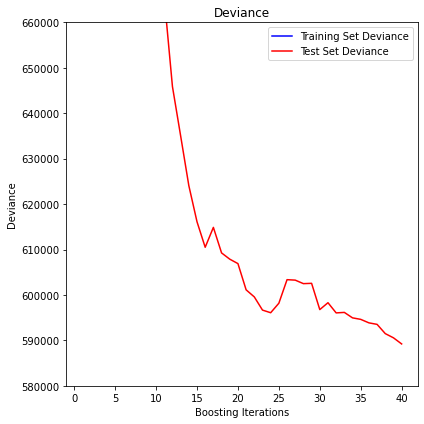

589215.8424318365


In [25]:
test_score = np.zeros((params["n_estimators"],), dtype=np.float64)
for i, y_pred in enumerate(model.staged_predict(X_test)):
    #test_score[i] = model.loss_(y_test, y_pred)   # This is just squared error
    test_score[i] = np.sqrt(((y_pred - y_test) ** 2).mean())  # this is RMSE

fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title("Deviance")
plt.plot(
    np.arange(params["n_estimators"]) + 1, model.train_score_,
    "b-", label="Training Set Deviance",
)
plt.plot(np.arange(params["n_estimators"]) + 1, test_score, "r-", label="Test Set Deviance")
plt.legend(loc="upper right")
plt.xlabel("Boosting Iterations")
plt.ylabel("Deviance")
#plt.ylim(0.03, 0.06)
plt.ylim(5.8e5, 6.6e5)
fig.tight_layout()
plt.show()
print(np.min(test_score))

# Train final model
Use all the data to train the final model once we've set the predictors and the hyperparameters

In [49]:
print(params)
print(pred_vars), len(pred_vars)

{'n_estimators': 40, 'learning_rate': 0.15, 'max_depth': 3, 'random_state': 56, 'subsample': 1, 'max_features': None, 'loss': 'squared_error'}
['Listed Price', 'Tax assessed value', 'Listed On', 'r3', 'r1', 'Total interior livable area', 'l1', 'Last Sold Price', 'Full bathrooms', 'Bathrooms']


(None, 10)

In [50]:
model = GradientBoostingRegressor(verbose = 1).set_params(**params).fit(X[pred_vars], y)

      Iter       Train Loss   Remaining Time 
         1 2054011942383.0447            2.79s
         2 1572627290631.9238            2.55s
         3 1223263745442.2815            2.45s
         4 962692662973.2238            2.37s
         5 771144857503.1027            2.27s
         6 622029707939.4421            2.16s
         7 512988201866.8933            2.13s
         8 433119020905.7556            2.07s
         9 371605905578.8995            2.01s
        10 324918202575.6410            1.93s
        20 176366284245.6205            1.26s
        30 146167448565.3074            0.63s
        40 135271435142.4395            0.00s


# Make Predictions

Do the same pre-processing on the test data that we do on the train data

In [42]:
test_p = preprocess_data(test, imp, imp_vars, train_medians, parking_types_train, 
                         heating_types_train, flooring_types_train, 
                         appliance_types_train, cities_train, types_train,
                        laundry_types_train)

In [51]:
test["Sold Price"] = model.predict(test_p[pred_vars])

In [52]:
test[["Id", "Sold Price"]].to_csv("../submission.csv", index = False)

In [53]:
test["Sold Price"].median(), test["Listed Price"].median()

(789544.54181973, 836000.0)